# Spectral optimization through BO with adaptive target setting

- Problem domain expert - Rama Vasudevan
- BO modeling -- Arpan Biswas

# Problem Description

Build a BO framework-

- Here we have a image data, where X is the input location of the image

- Each location in the image, we have a spectral data, from where user select if the data is good/bad (discrete choice). We take the means of all good spectral only to generate the target spectral.

- At the mid of execution, the user also have option to either eliminate (or update the preferance) all the previously stored (if user suddenly find a desired spectral) spectral, and put more weights on new found spectral.

- The goal is to build a optimization (BO) model where we adaptively sample towards region (in image) of good spectral, and find optimal location point closest to the current chosen target spectral (as per user voting).

# Workflow: Run BO to find the optimal location for user-desired spectral as per voting

- Here we vote the quality of spectral, for example: trying to get a greater loop area, with minimal noise and be as much towards theoritical hysteresis loop.

- User interaction part:
    1. Load Data. Currently, we have two dataset to choose: BEPFM and IV.
    2. Initialize parameters. Select # of randomly selected starting samples (pre BO) and # of total BO iterations.
    3. During the play (for each function evaluation)-

        1. View spectral image. User have three rating options as 0, 1, 2: 0-Bad, 1-Good, 2-Very good.
              1. If user rated as Good or Very Good, and user already have a current target spectral (user already selected at least one good/very good spectral in earlier iterations), another message pops up if the user want to update preference of new spectral Vs the current target spectral(Y or N).
                1. If user choose "Y", user have option (any number between 0-1) to provide weights of new spectral. For example: If user provide 1 as input, the updated target spectral will be only the new chosen spectral and all the other earlier selected good spectral will be eliminated from target.
                2. If user choose "N", as default the updated target spectral is the mean of all the earlier selected spectral and the new spectral.


- After END OF PLAY, the code automatically save below data (serially) in optim.results.npy

  1. Best locations, from evaluated samples and GP estimated

  2. User rating of spectral at each evaluated locations in image

  3. the matrices of evaluated location and the respective obj values


List of dataset: bepfm or iv
Load dataset :Options: bepfm or iv bepfm
#################################################################
Enter number of randomly selected starting samples: Recommended between 10 to 20
Enter starting samples: 2
Enter number of BO iterations: Recommended between 100 to 150
Enter BO iterations: 2
#################################################################
Now start analysis: Loading Data
Complete Data Loading...
#################################################################
#################################################################
Sample #1


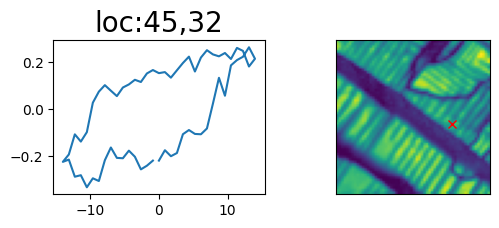

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
#################################################################
Sample #2


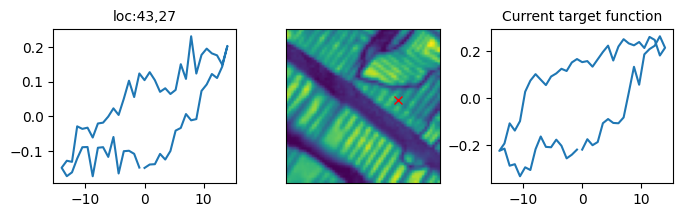

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): n
#################################################################
Initial evaluation complete. Start BO
#################################################################


<Figure size 640x480 with 0 Axes>

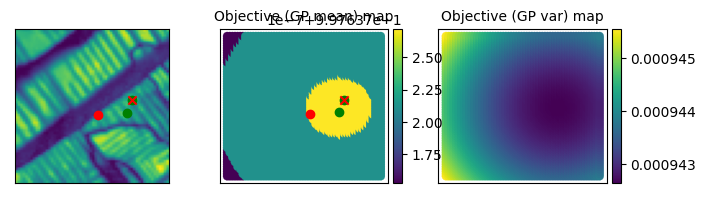

Sample #3


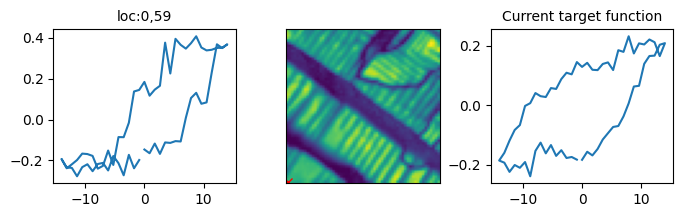

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #4


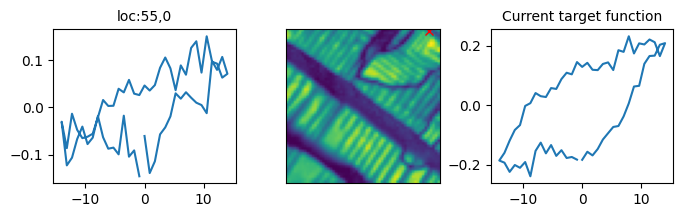

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
#################################################################
Max. sampling reached, model stopped
#################################################################


<Figure size 640x480 with 0 Axes>

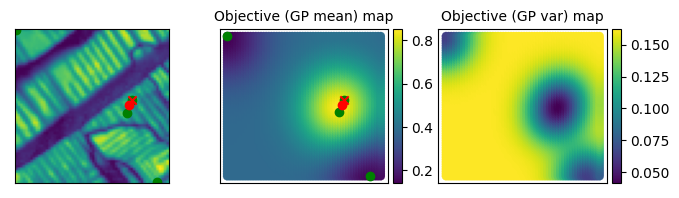

#################################################################
Display best spectrals


C:\Users\arpan\PycharmProjects\pythonProject1\venv\lib\site-packages\numpy\lib\npyio.py:501: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
C:\Users\arpan\PycharmProjects\pythonProject1\venv\lib\site-packages\numpy\lib\npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


<Figure size 640x480 with 0 Axes>

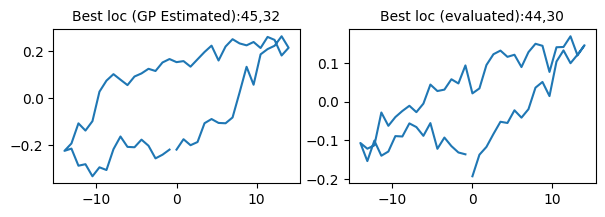

#################################################################
End of Analysis


In [9]:
import sys
import gdown
import torch
from torchvision import datasets, transforms
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy as np
import random
#import kornia as K
#import kornia.metrics as metrics
from PIL import Image
from typing import Tuple
import ipywidgets as widgets
from IPython.display import display
import pylab as pl
from IPython.display import clear_output
import pdb
from skimage.transform import resize
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import gpim
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec
from copy import deepcopy
#import pyroved as pv
#import atomai as aoi
from typing import Union
import pickle


# Import GP and BoTorch functions
import gpytorch as gpt
from botorch.models import SingleTaskGP, ModelListGP
#from botorch.models import gpytorch
from botorch.fit import fit_gpytorch_model
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils import standardize
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import ExpectedImprovement
from botorch.sampling import IIDNormalSampler
from botorch.sampling import SobolQMCNormalSampler
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.constraints import GreaterThan

from botorch.generation import get_best_candidates, gen_candidates_torch
from botorch.optim import gen_batch_initial_conditions

from gpytorch.models import ExactGP
from mpl_toolkits.axes_grid1 import make_axes_locatable
from smt.sampling_methods import LHS
from torch.optim import SGD
from torch.optim import Adam
from scipy.stats import norm
from scipy.interpolate import interp1d


class SimpleCustomGP(ExactGP, GPyTorchModel):
    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        #self.mean_module = LinearMean(train_X.shape[-1])
        self.covar_module = ScaleKernel(
            #base_kernel=MaternKernel(nu=2.5, ard_num_dims=train_X.shape[-1]),
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

class play_varTBO():

    def __init__(self):
        print("List of dataset: bepfm or iv")
        input_args = str(input("Load dataset :Options: bepfm or iv "))
        print("#################################################################")
        print("Enter number of randomly selected starting samples: Recommended between 10 to 20")
        start_samples = float(input("Enter starting samples: "))
        print("Enter number of BO iterations: Recommended between 100 to 150")
        BO_iter = float(input("Enter BO iterations: "))
        sample_args = [start_samples, BO_iter]
        print("#################################################################")
        print("Now start analysis: Loading Data")
        self.data_load(input_args, sample_args)

    def func_obj(self, X, spec_norm, V, wcount_good, target_func, vote):
        idx1 = int(X[0, 0])
        idx2 = int(X[0, 1])
        rf = 1
        if (wcount_good == 0): #We dont find a good loop yet from all initial sampling and thus target is unknown
            mse_spectral = torch.rand(1)*(1)+1 # Unif[1, 2] A sufficiently large value as we want to avoid selecting bad loops,
            # When we have a target, we will recalculate again to get more accuract estimate
            R = vote*rf

        else:
            #Calculate dissimilarity (mse) between target and ith loop shape
            dev2_spectral = (target_func-spec_norm[idx1, idx2, :])**2
            mse_spectral = torch.mean(dev2_spectral)
            #Calculate reward as per voting, this will minimize the risk of similar function values of good and bad loop shape with similar mse
            R = vote*rf

        #This is the basic setting of obj func-- we can incorporate more info as per domain knowledge to improve
        #Into maximization problem
        obj = R - mse_spectral #Maximize reward and negative mse

        return obj

    def generate_targetobj(self, X, spec_norm, lowres_image, V, wcount_good, target_func):
        #count_good= 0
        idx1 = int(X[0, 0])
        idx2 = int(X[0, 1])
        #print(idx1, idx2)
        #target_loop = torch.empty(loop_norm.shape[2])
        if (wcount_good == 0):
        # Figure for user choice
            fig,ax=plt.subplots(ncols=2,figsize=(6,2))
            ax[0].plot(V,spec_norm[idx1, idx2, :])
            ax[0].set_title('loc:' +str(idx1) +"," + str(idx2), fontsize = 20)
            #ax[0].axes.xaxis.set_visible(False)
            #ax[0].axes.yaxis.set_visible(False)
            ax[1].imshow(lowres_image.detach().numpy())
            ax[1].plot(idx1, idx2, 'x', color="red")
            ax[1].axes.xaxis.set_visible(False)
            ax[1].axes.yaxis.set_visible(False)

            plt.show()

        else:
        # Figure for user choice
            fig,ax=plt.subplots(ncols=3,figsize=(8,2))
            ax[0].plot(V,spec_norm[idx1, idx2, :])
            ax[0].set_title('loc:' +str(idx1) +"," + str(idx2), fontsize = 10)
            #ax[0].axes.xaxis.set_visible(False)
            #ax[0].axes.yaxis.set_visible(False)
            ax[1].imshow(lowres_image.detach().numpy())
            ax[1].plot(idx1, idx2, 'x', color="red")
            ax[1].axes.xaxis.set_visible(False)
            ax[1].axes.yaxis.set_visible(False)
            ax[2].plot(V,target_func)
            ax[2].set_title('Current target function', fontsize = 10)
            #ax[2].axes.xaxis.set_visible(False)
            #ax[2].axes.yaxis.set_visible(False)
            plt.show()

        print("Rating: 0-Bad, 1-Good, 2-Very good")
        vote = float(input("enter rating: "))
        if(vote>0):
            newspec_wt = 1
            if ((wcount_good) > 0): #Only if we already have selected good spectral in early iterations
                newspec_pref = str(input("Do you want to update preference to new spectral over prioir mean target (Y/N): "))
                if (newspec_pref == 'Y' or newspec_pref == 'y'):
                    print("Provide weights between 0 and 1: 1 being all the weights to new spectral as new target")
                    newspec_wt = float(input("enter weightage: "))
                else:
                    newspec_wt = 0.5
            wcount_good =wcount_good + vote
            target_func = (((1-newspec_wt)*target_func*(wcount_good-vote))\
                           + (newspec_wt*vote*spec_norm[idx1, idx2, :]))/(((wcount_good-vote)*(1-newspec_wt))\
                           + (vote*newspec_wt))
        return vote, wcount_good, target_func

    def optimize_hyperparam_trainGP(self, train_X, train_Y):
        # Gp model fit

        gp_surro = SimpleCustomGP(train_X, train_Y)
        gp_surro = gp_surro.double()
        gp_surro.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
        mll1 = ExactMarginalLogLikelihood(gp_surro.likelihood, gp_surro)
        # fit_gpytorch_model(mll)
        mll1 = mll1.to(train_X)
        gp_surro.train()
        gp_surro.likelihood.train()
        ## Here we use Adam optimizer with learning rate =0.1, user can change here with different algorithm and/or learning rate for each GP
        optimizer1 = Adam([{'params': gp_surro.parameters()}], lr=0.1) #0.01 set for BEPFM data, recommended to check the lr for any new data
        #optimizer1 = SGD([{'params': gp_surro.parameters()}], lr=0.0001)

        NUM_EPOCHS = 150

        for epoch in range(NUM_EPOCHS):
            # clear gradients
            optimizer1.zero_grad()
            # forward pass through the model to obtain the output MultivariateNormal
            output1 = gp_surro(train_X)
            # Compute negative marginal log likelihood
            loss1 = - mll1(output1, gp_surro.train_targets)
            # back prop gradients
            loss1.backward(retain_graph=True)
            # print last iterations
            if (epoch + 1) > NUM_EPOCHS: #Stopping the print for now
                print("GP Model trained:")
                print("Iteration:" + str(epoch + 1))
                print("Loss:" + str(loss1.item()))
                # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
                print("noise:" + str(gp_surro.likelihood.noise.item()))


            optimizer1.step()

        gp_surro.eval()
        gp_surro.likelihood.eval()
        return gp_surro

    def cal_posterior(self, gp_surro, test_X):
        y_pred_means = torch.empty(len(test_X), 1)
        y_pred_vars = torch.empty(len(test_X), 1)
        t_X = torch.empty(1, test_X.shape[1])
        for t in range(0, len(test_X)):
            with torch.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
                gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False,
                                                          solves=True), \
                gpt.settings.max_cg_iterations(100), \
                gpt.settings.max_preconditioner_size(80), \
                gpt.settings.num_trace_samples(128):

                    t_X[:, 0] = test_X[t, 0]
                    t_X[:, 1] = test_X[t, 1]
                    #t_X = test_X.double()
                    y_pred_surro = gp_surro.posterior(t_X)
                    y_pred_means[t, 0] = y_pred_surro.mean
                    y_pred_vars[t, 0] = y_pred_surro.variance

        return y_pred_means, y_pred_vars

    def acqmanEI(self, y_means, y_vars, train_Y, ieval):


        y_means = y_means.detach().numpy()
        y_vars = y_vars.detach().numpy()
        y_std = np.sqrt(y_vars)
        fmax = train_Y.max()
        fmax = fmax.detach().numpy()
        best_value = fmax
        EI_val = np.zeros(len(y_vars))
        Z = np.zeros(len(y_vars))
        eta = 0.01

        for i in range(0, len(y_std)):
            if (y_std[i] <=0):
                EI_val[i] = 0
            else:
                Z[i] =  (y_means[i]-best_value-eta)/y_std[i]
                EI_val[i] = (y_means[i]-best_value-eta)*norm.cdf(Z[i]) + y_std[i]*norm.pdf(Z[i])

        # Eliminate evaluated samples from consideration to avoid repeatation in future sampling
        EI_val[ieval] = -1
        acq_val = np.max(EI_val)
        acq_cand = [k for k, j in enumerate(EI_val) if j == acq_val]
        #print(acq_val)
        return acq_cand, acq_val, EI_val

    def normalize_get_initialdata_KL(self, X, fix_params, num, m):

        X_feas = torch.empty((X.shape[1]**X.shape[0], X.shape[0]))
        k=0
        spec_norm, lowres_image, V  = fix_params[0], fix_params[1], fix_params[2]
        for t1 in range(0, X.shape[1]):
            for t2 in range(0, X.shape[1]):
                X_feas[k, 0] = X[0, t1]
                X_feas[k, 1] = X[1, t2]
                k=k+1

        X_feas_norm = torch.empty((X_feas.shape[0], X_feas.shape[1]))
        #train_X = torch.empty((len(X), num))
        #train_X_norm = torch.empty((len(X), num))
        train_Y = torch.empty((num, 1))
        pref = torch.empty((num, 1))


        # Normalize X
        for i in range(0, X_feas.shape[1]):
            X_feas_norm[:, i] = (X_feas[:, i] - torch.min(X_feas[:, i])) / (torch.max(X_feas[:, i]) - torch.min(X_feas[:, i]))



        # Select starting samples randomly as training data
        np.random.seed(0)
        idx = np.random.randint(0, len(X_feas), num)
        train_X = X_feas[idx]
        train_X_norm = X_feas_norm[idx]
        #print(train_X)
        #print(train_X_norm)

        #Evaluate initial training data
        x = torch.empty((1,2))
        # First generate target loop, based on initial training data
        wcount_good= 0
        target_func = torch.zeros(spec_norm.shape[2])
        for i in range(0, num):
            x[0, 0] = train_X[i, 0]
            x[0, 1] = train_X[i, 1]
            print("#################################################################")
            print("Sample #" + str(m + 1))
            pref[i, 0], wcount_good, target_func = self.generate_targetobj(x, spec_norm, lowres_image, V, wcount_good, target_func)
            m = m + 1

        # Once target loop is defined (unless are loops are selected bad by user), we compute the obj
        for i in range(0, num):
            x[0, 0] = train_X[i, 0]
            x[0, 1] = train_X[i, 1]

            #print("Function eval #" + str(m + 1))

            train_Y[i, 0] = self.func_obj(x, spec_norm, V, wcount_good, target_func, pref[i, 0])
            #m = m + 1
        #print(pref)
        #print(train_Y)
        var_params = [wcount_good, pref, target_func]

        return X_feas, X_feas_norm, train_X, train_X_norm, train_Y, var_params, idx, m

    def augment_newdata_KL(self, acq_X, acq_X_norm, train_X, train_X_norm, train_Y, fix_params, var_params, m):
        spec_norm, lowres_image, V  = fix_params[0], fix_params[1], fix_params[2]
        wcount_good, pref, target_func = var_params[0], var_params[1], var_params[2]

        nextX = acq_X
        nextX_norm = acq_X_norm
        #train_X_norm = torch.cat((train_X_norm, nextX_norm), 0)
        #train_X_norm = train_X_norm.double()
        train_X_norm = torch.vstack((train_X_norm, nextX_norm))
        train_X = torch.vstack((train_X, nextX))

        p = torch.empty(1, 1)
        x = torch.empty((1,2))
        x[0, 0] = train_X[-1, 0]
        x[0, 1] = train_X[-1, 1]

        print("Sample #" + str(m + 1))
        #Vote for new spectral sample and update(or not) target spectral function
        p[0, 0], wcount_good, target_func = self.generate_targetobj(x, spec_norm, lowres_image, V, wcount_good, target_func)
        pref = torch.vstack((pref, p)) #Augment pref matrix

        if (p[0, 0] == 0):
          # If target loop is not updated, we eval for the new samples only as the func value for others remain the same

            next_feval = torch.empty(1, 1)
            next_feval[0, 0] = self.func_obj(x, spec_norm, V, wcount_good, target_func, pref[-1, 0])
            train_Y = torch.vstack((train_Y, next_feval))
        else:
            # If target loop is updated, we reevaluate the obj of old spectral samples and eval for the new samples
            train_Y = torch.empty((train_X.shape[0], 1))
            for i in range(0, train_X.shape[0]):
                x[0, 0] = train_X[i, 0]
                x[0, 1] = train_X[i, 1]
                train_Y[i, 0] = self.func_obj(x, spec_norm, V, wcount_good, target_func, pref[i, 0])


        #print(pref)
        #print(train_Y)
        var_params = [wcount_good, pref, target_func]
        m = m + 1
        return train_X, train_X_norm, train_Y, var_params, m

    def plot_iteration_results(self, train_X, train_Y, test_X, y_pred_means, y_pred_vars, fix_params, i):
        spec_norm, lowres_image, V  = fix_params[0], fix_params[1], fix_params[2]
        pen = 10**0
        #Best solution among the evaluated data

        loss = torch.max(train_Y)
        ind = torch.argmax(train_Y)
        X_opt = torch.empty((1,2))
        #X_opt = train_X[ind, :]
        X_opt[0, 0] = train_X[ind, 0]
        X_opt[0, 1] = train_X[ind, 1]


        # Best estimated solution from GP model considering the non-evaluated solution

        loss = torch.max(y_pred_means)
        ind = torch.argmax(y_pred_means)
        X_opt_GP = torch.empty((1,2))
        #X_opt = train_X[ind, :]
        X_opt_GP[0, 0] = test_X[ind, 0]
        X_opt_GP[0, 1] = test_X[ind, 1]

        #Objective map
        plt.figure()

        fig,ax=plt.subplots(ncols=3,figsize=(8,2))
        a= ax[0].imshow(lowres_image.detach().numpy(), origin="lower")
        ax[0].scatter(train_X[:,0], train_X[:,1], marker='o', c='g')
        ax[0].scatter(X_opt[0, 0], X_opt[0, 1], marker='x', c='r')
        ax[0].scatter(X_opt_GP[0, 0], X_opt_GP[0, 1], marker='o', c='r')
        ax[0].axes.xaxis.set_visible(False)
        ax[0].axes.yaxis.set_visible(False)


        a = ax[1].scatter(test_X[:,0], test_X[:,1], c=y_pred_means/pen, cmap='viridis', linewidth=0.2)
        ax[1].scatter(train_X[:,0], train_X[:,1], marker='o', c='g')
        ax[1].scatter(X_opt[0, 0], X_opt[0, 1], marker='x', c='r')
        ax[1].scatter(X_opt_GP[0, 0], X_opt_GP[0, 1], marker='o', c='r')
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(a, cax=cax, orientation='vertical')
        ax[1].set_title('Objective (GP mean) map', fontsize=10)
        ax[1].axes.xaxis.set_visible(False)
        ax[1].axes.yaxis.set_visible(False)
        #ax[1].colorbar(a)

        b = ax[2].scatter(test_X[:,0], test_X[:,1], c=y_pred_vars/(pen**2), cmap='viridis', linewidth=0.2)
        divider = make_axes_locatable(ax[2])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(b, cax=cax, orientation='vertical')
        ax[2].set_title('Objective (GP var) map', fontsize=10)
        ax[2].axes.xaxis.set_visible(False)
        ax[2].axes.yaxis.set_visible(False)
        #ax[2].colorbar(b)
        plt.show()


        return X_opt, X_opt_GP

    def BO_vartarget(self, X, fix_params, num_start, N):
        num = num_start
        m = 0
        # Initialization: evaluate few initial data normalize data
        test_X, test_X_norm, train_X, train_X_norm, train_Y, var_params, idx, m = \
            self.normalize_get_initialdata_KL(X, fix_params, num, m)

        print("#################################################################")
        print("Initial evaluation complete. Start BO")
        print("#################################################################")
        ## Gp model fit
        # Calling function to fit and optimizize Hyperparameter of Gaussian Process (using Adam optimizer)
        # Input args- Torch arrays of normalized training data, parameter X and objective eval Y
        # Output args- Gaussian process model lists
        gp_surro = self.optimize_hyperparam_trainGP(train_X_norm, train_Y)

        for i in range(1, N + 1):
            # Calculate posterior for analysis for intermidiate iterations
            y_pred_means, y_pred_vars = self.cal_posterior(gp_surro, test_X_norm)
            if ((i == 1) or ((i % 10) == 0)):
                # Plotting functions to check the current state exploration and Pareto fronts
                X_eval, X_GP = self.plot_iteration_results(train_X, train_Y, test_X, y_pred_means, y_pred_vars, fix_params, i)

            #print(idx)
            acq_cand, acq_val, EI_val = self.acqmanEI(y_pred_means, y_pred_vars, train_Y, idx)
            val = acq_val
            ind = np.random.choice(acq_cand) # When multiple points have same acq values
            idx = np.hstack((idx, ind))


            ################################################################
            ## Find next point which maximizes the learning through exploration-exploitation
            if (i == 1):
                val_ini = val
            # Check for convergence
            if ((val) < 0):  # Stop for negligible expected improvement
                print("Model converged due to sufficient learning over search space ")
                break
            else:
                nextX = torch.empty((1, len(X)))
                nextX_norm = torch.empty(1, len(X))
                nextX[0,:] = test_X[ind, :]
                nextX_norm [0, :] = test_X_norm[ind, :]

                # Evaluate true function for new data, augment data
                train_X, train_X_norm, train_Y, var_params, m =\
                 self.augment_newdata_KL(nextX, nextX_norm, train_X, train_X_norm, train_Y, fix_params, var_params, m)

                # Gp model fit
                # Updating GP with augmented training data
                gp_surro = self.optimize_hyperparam_trainGP(train_X_norm, train_Y)

        ## Final posterior prediction after all the sampling done

        if (i == N):
            print("#################################################################")
            print("Max. sampling reached, model stopped")
            print("#################################################################")

        #Optimal GP learning
        gp_opt = gp_surro
        # Posterior calculation with converged GP model
        y_pred_means, y_pred_vars = self.cal_posterior(gp_opt, test_X_norm)
        # Plotting functions to check final iteration
        X_opt, X_opt_GP = self.plot_iteration_results(train_X, train_Y, test_X, y_pred_means, y_pred_vars, fix_params, i)
        explored_data = [train_X, train_Y]
        final_GP_estim = [y_pred_means, y_pred_vars]
        user_votes = var_params[1]
        optim_results = [X_opt, X_opt_GP, user_votes, explored_data]

        #Save few data
        np.save("optim_results", optim_results)


        return  X_opt, X_opt_GP, var_params, explored_data, final_GP_estim

    def data_load(self, input_args, sample_args):

        if (input_args == 'BEPFM' or input_args == 'bepfm'):
            #!pip install -U gdown

            #!gdown "https://drive.google.com/uc?id=1PoklVNuIwhAMbig0LvxW-zAK82et_aL-"
            #!gdown "https://drive.google.com/uc?id=11v5wHmMT0xYcxAYejjxLKz1QARST_JRn"
            #!gdown "https://drive.google.com/uc?id=1jQZIW7uiNV0J-mDl1yNylhNA6rRFnMM4"

            gdown.download("https://drive.google.com/uc?id=1PoklVNuIwhAMbig0LvxW-zAK82et_aL-", "loop_mat.npy", quiet=True)
            gdown.download("https://drive.google.com/uc?id=11v5wHmMT0xYcxAYejjxLKz1QARST_JRn", "dc_vec.npy", quiet=True)
            gdown.download("https://drive.google.com/uc?id=1jQZIW7uiNV0J-mDl1yNylhNA6rRFnMM4", "bepfm_image.npy", quiet=True)


            #boptim_results = np.load("boptim_results.npy", allow_pickle=True)
            loop_mat = np.load("loop_mat.npy")
            dc_vec = np.load("dc_vec.npy")
            bepfm_image = np.load("bepfm_image.npy")

            n_spectral = 2 # Consider the final loop measurement
            loop_mat_grid = np.reshape(loop_mat,(60, 60, loop_mat.shape[1], loop_mat.shape[2]))
            loop = loop_mat_grid[:, :, :, n_spectral]
            #print(loop.shape)

            #Tranform the image data to map with spectral data
            grid_dim = loop.shape[1]
            lowres_image = resize(bepfm_image, (grid_dim, grid_dim))
            #print(bepfm_lowres_image.shape)

            #Consider single sweep of voltage to generate hysteresis loop
            l_vsweep= loop.shape[2]
            V= dc_vec[:l_vsweep]
            #print(V.shape)

            #Normalize loop data (avoiding drift in data)
            loop_norm = np.zeros((loop.shape))
            for i in range(0, loop.shape[0]):
              for j in range(0, loop.shape[1]):
                loop_norm[i, j, :] = (loop[i,j,:]- np.mean(loop[i,j,:]))*1e4

            spec = loop_norm
            #print(loop.shape, loop_norm.shape)
        elif (input_args == 'IV' or input_args == 'iv'):
            #!pip install -U gdown
            #!gdown "https://drive.google.com/uc?id=1l9-i36puXUcGXQMGSgVjci_x-aNC4bzp"
            #!gdown "https://drive.google.com/uc?id=1-YMtG0kjypcmVvJDJwaJ1QUf5Ar32uj-"

            gdown.download("https://drive.google.com/uc?id=1l9-i36puXUcGXQMGSgVjci_x-aNC4bzp", "cur_mat_raw.npy", quiet=True)
            gdown.download("https://drive.google.com/uc?id=1-YMtG0kjypcmVvJDJwaJ1QUf5Ar32uj-", "cur_mat_vdc.npy", quiet=True)


            iv_dat = np.load("cur_mat_raw.npy")
            iv_dat = iv_dat
            dc_vec = np.load("cur_mat_vdc.npy")
            iv_dat = iv_dat.reshape(50,50,iv_dat.shape[1])*1e11
            V= dc_vec
            #print(iv_dat.shape)
            #print(V.shape)

            #Generate the grid param space (taking means of spectral values at each grid location)
            lowres_image = np.mean(iv_dat, axis=2)
            lowres_image = np.transpose(lowres_image)
            #print(iv_lowres_image.shape)
            #plt.figure()
            #plt.imshow(iv_lowres_image, origin="lower")
            #plt.colorbar()

            #Normalize loop data (avoiding drift in data)
            spec = np.zeros((iv_dat.shape))
            for i in range(0, iv_dat.shape[0]):
              for j in range(0, iv_dat.shape[1]):
                spec[i, j, :] = (iv_dat[i,j,:]- np.mean(iv_dat[i,j,:]))

        else:
            print("Error: Choose correct file name: Check spelling")
            sys.exit()


        #tranform data into torch
        spec = torch.from_numpy(spec)
        V = torch.from_numpy(V)
        lowres_image= torch.from_numpy(lowres_image)

        grid_x1 = torch.arange(0, lowres_image.shape[0])
        grid_x2 = torch.arange(0, lowres_image.shape[1])

        X= torch.vstack((grid_x1, grid_x2))

        #Fixed parameters of VAE model
        fix_params = [spec, lowres_image, V]
        num_start = int(sample_args[0])
        N = int(sample_args[1])
        print("Complete Data Loading...")
        print("#################################################################")

        X_opt, X_opt_GP, var_params, explored_locs, final_GP_estim = self.BO_vartarget(X, fix_params, num_start, N)


        #Display
        print("#################################################################")
        print("Display best spectrals")
        plt.figure()

        fig,ax=plt.subplots(ncols=2,figsize=(7,2))

        #Optimal from estimated GP
        idx1 = int(X_opt[0, 0])
        idx2 = int(X_opt[0, 1])
        ax[0].plot(V, spec[idx1,idx2,:])
        ax[0].set_title('Best loc (GP Estimated):' +str(idx1) +"," + str(idx2), fontsize = 10)

        #Optimal from evaluated samples
        idx1 = int(X_opt_GP[0, 0])
        idx2 = int(X_opt_GP[0, 1])
        ax[1].plot(V, spec[idx1,idx2,:])
        ax[1].set_title('Best loc (evaluated):' +str(idx1) +"," + str(idx2), fontsize = 10)
        plt.show()
        print("#################################################################")
        print("End of Analysis")

play_varTBO()